# Agenda
Spectral clustering of GPs' bitmaps.



In [52]:
# Installing Libraries (if not installed)
#!pip3 install jupyterlab-git
#!pip3 install matplotlib
#!pip3 install scikit-learn
#!pip3 install seaborn
#!pip3 install numpy
#!pip3 install pandas
#!pip3 install so4gp
#!pip3 install scipy
#!pip3 install sympy

# Import libraries <a name="lib-import"></a>

In [53]:
# Importing Libraries
import pandas as pd
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sympy
import scipy
import math


from scipy.sparse import csgraph, csr_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import homogeneity_score, completeness_score,v_measure_score, confusion_matrix, accuracy_score
from numpy import linalg as la

In [54]:
import so4gp as sgp

## Data set
Retrieving data set and the features

In [55]:
#ds = sgp.DataGP('./data/DATASET.csv')
#ds = sgp.DataGP('./data/c2k_02k.csv')
ds = sgp.DataGP('./data/breast_cancer.csv')


data_size = ds.row_count
features = np.array(ds.data, dtype=np.float64)
features

array([[ 48.        ,  23.5       ,  70.        , ...,   7.99585   ,
        417.114     ,   1.        ],
       [ 83.        ,  20.69049454,  92.        , ...,   4.06405   ,
        468.786     ,   1.        ],
       [ 82.        ,  23.12467037,  91.        , ...,   9.27715   ,
        554.697     ,   1.        ],
       ...,
       [ 65.        ,  32.05      ,  97.        , ...,  10.33      ,
        314.05      ,   2.        ],
       [ 72.        ,  25.59      ,  82.        , ...,   3.27      ,
        392.46      ,   2.        ],
       [ 86.        ,  27.18      , 138.        , ...,   4.35      ,
         90.09      ,   2.        ]])

In [56]:
sgp.graank('./data/breast_cancer.csv', min_sup=0.6)

'{"Algorithm": "GRAANK", "Patterns": [[["Insulin+", "BMI+"], 0.612], [["HOMA+", "BMI+"], 0.614], [["Leptin+", "BMI+"], 0.732], [["Insulin-", "BMI-"], 0.612], [["BMI-", "HOMA-"], 0.614], [["BMI-", "Leptin-"], 0.732], [["Insulin+", "Glucose+"], 0.637], [["HOMA+", "Glucose+"], 0.697], [["Insulin-", "Glucose-"], 0.637], [["Glucose-", "HOMA-"], 0.697], [["Insulin+", "HOMA+"], 0.94], [["Leptin+", "Insulin+"], 0.659], [["Insulin-", "HOMA-"], 0.94], [["Insulin-", "Leptin-"], 0.659], [["Leptin+", "HOMA+"], 0.659], [["Leptin-", "HOMA-"], 0.659], [["MCP.1+", "Resistin+"], 0.672], [["MCP.1-", "Resistin-"], 0.672], [["Insulin+", "HOMA+", "Glucose+"], 0.637], [["Insulin-", "Glucose-", "HOMA-"], 0.637], [["Leptin+", "Insulin+", "HOMA+"], 0.629], [["Insulin-", "Leptin-", "HOMA-"], 0.629]]}'

In [57]:
feature_X = features[:, [3,4]]
feature_X

array([[ 2.707     ,  0.46740867],
       [ 3.115     ,  0.70689733],
       [ 4.498     ,  1.00965107],
       [ 3.226     ,  0.61272493],
       [ 3.549     ,  0.8053864 ],
       [ 3.226     ,  0.73208693],
       [ 4.69      ,  0.89078733],
       [ 6.47      ,  1.88320133],
       [ 3.35      ,  0.80154333],
       [ 4.952     ,  1.01383947],
       [ 3.469     ,  0.6674356 ],
       [ 5.663     ,  1.14543613],
       [ 4.09      ,  0.82727067],
       [ 6.107     ,  1.33      ],
       [ 5.782     ,  1.06967   ],
       [ 7.553     ,  1.6       ],
       [ 2.869     ,  0.59      ],
       [18.077     ,  3.79014433],
       [ 4.427     ,  1.03739367],
       [14.026     ,  3.0099796 ],
       [ 4.345     ,  0.92171933],
       [ 4.53      ,  0.972138  ],
       [ 5.81      ,  1.203832  ],
       [ 4.376     ,  0.9067072 ],
       [ 5.537     ,  1.229214  ],
       [ 6.76      ,  1.38399733],
       [ 6.703     ,  1.75261107],
       [ 9.245     ,  2.05239   ],
       [ 6.817     ,

## Train similirity labels

### a. Retrieving training data set (X, y)

In [58]:
def compute_nz(row, i):
    #print(row[i:])
    nz = np.nonzero(row)
    for k in range(nz[0].size):
        if nz[0].size > 0:
            j = nz[0][k]
            if j > i:
                return j
    return 0

In [59]:
# X (2 features at a time)
X = np.zeros((data_size, data_size))
y  = np.zeros((data_size,))

for i in range(data_size):
    for j in range(data_size):
        if (feature_X[i][0] == feature_X[j][0]) or (feature_X[i][1] == feature_X[j][1]):
            pass
        elif (feature_X[i][0] > feature_X[j][0]) and (feature_X[i][1] > feature_X[j][1]):
            X[i][j] = 1
            X[j][i] = 1
        elif (feature_X[i][0] > feature_X[j][0]) and (feature_X[i][1] < feature_X[j][1]):
            X[i][j] = 2 #-1
            X[j][i] = 2 #-1

cols = np.arange(data_size)
rows = np.arange(data_size)
# print (rows)
for i in cols:
    #u_count = np.unique(X[i], return_index=True, return_counts=True)
    #print(u_count)
    #i_max = u_count[2].argmax()
    #y[i] = u_count[0][i_max] 
    
    # (i, j)
    # Column i, Row j
    conns = X[i]
    j = compute_nz(conns,i)
    if j > 0:
        #y[i] = X[i][j]
        if (y[i] == 0) or (y[i] == X[i][j]):
            y[i] = X[i][j]
        y[j] = X[i][j]
        print(str(i) + ', ' + str(j))
    #else:  # To be ignored
    #    print(str(i) + ', NaN')
    #    pass

X

0, 1
1, 2
2, 3
3, 4
4, 5
5, 6
6, 7
7, 8
8, 9
9, 10
10, 11
11, 12
12, 13
13, 14
14, 15
15, 16
16, 17
17, 18
18, 19
19, 20
20, 21
21, 22
22, 23
23, 24
24, 25
25, 26
26, 27
27, 28
28, 29
29, 30
30, 31
31, 32
32, 33
33, 34
34, 35
35, 36
36, 37
37, 38
38, 39
39, 40
40, 41
41, 42
42, 43
43, 44
44, 45
45, 46
46, 47
47, 48
48, 49
49, 50
50, 51
51, 52
52, 53
53, 54
54, 55
55, 56
56, 57
57, 58
58, 59
59, 60
60, 61
61, 62
62, 63
63, 64
64, 65
65, 66
66, 67
67, 68
68, 69
69, 70
70, 71
71, 72
72, 73
73, 74
74, 75
75, 76
76, 77
77, 78
78, 79
79, 80
80, 81
81, 82
82, 83
83, 84
84, 85
85, 86
86, 87
87, 88
88, 89
89, 90
90, 91
91, 92
92, 93
93, 94
94, 95
95, 96
96, 97
97, 98
98, 99
99, 100
100, 101
101, 102
102, 103
103, 104
104, 105
105, 106
106, 107
107, 108
108, 109
109, 110
110, 111
111, 112
112, 113
113, 114
114, 115


array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [60]:
#y  = np.array([2,2,2,2,2], dtype=int)
print(y)
print(feature_X)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[ 2.707       0.46740867]
 [ 3.115       0.70689733]
 [ 4.498       1.00965107]
 [ 3.226       0.61272493]
 [ 3.549       0.8053864 ]
 [ 3.226       0.73208693]
 [ 4.69        0.89078733]
 [ 6.47        1.88320133]
 [ 3.35        0.80154333]
 [ 4.952       1.01383947]
 [ 3.469       0.6674356 ]
 [ 5.663       1.14543613]
 [ 4.09        0.82727067]
 [ 6.107       1.33      ]
 [ 5.782       1.06967   ]
 [ 7.553       1.6       ]
 [ 2.869       0.59      ]
 [18.077       3.79014433]
 [ 4.427       1.03739367]
 [14.026       3.0099796 ]
 [ 4.345       0.92171933]
 [ 4.53        0.972138  ]
 [ 5.81        1.203832  ]
 [ 4.376       0.9067072 

### b. Constructing KNN Classifier

Using supervised learning

Adopted from [Analyticsvidhya](https://www.analyticsvidhya.com/blog/2021/01/a-quick-introduction-to-k-nearest-neighbor-knn-classification-using-python/)

In [61]:
# Splitting the dataset into the Training set (0.5 of data set sample) and Test set (0.5 of sample size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state = 0)
#X_train, X_test, y_train, y_test = train_test_split(feature_X, y, test_size = 0.50, random_state = 0)


In [62]:
# Feature Scaling (if you have large values otherwise skip)

#sc = StandardScaler()
#X_train = sc.fit_transform(X_train)
#X_test = sc.transform(X_test)

In [63]:
# Training the K-NN model on the Training set
n = int(math.sqrt(data_size))
classifier = KNeighborsClassifier(n_neighbors = n, metric = 'minkowski', p = 2)  # default parameters
classifier.fit(X_train, y_train)


KNeighborsClassifier(n_neighbors=10)

In [64]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1.])

In [65]:
# Making the Confusion Matrix
confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred)

(array([[56,  0],
        [ 2,  0]], dtype=int64),
 0.9655172413793104)

## Proposed Approach
1. We will have to decompose superset GPs into their individual 2x2 subsets and compute their supports through clustering. 

2. Then, we apply antimonotonicity principle to infer the support of the superset.

## a. KMeans Clustering
Produces labels that are not very accurate in partitioning data points.

(array([1.]), array([116], dtype=int64))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


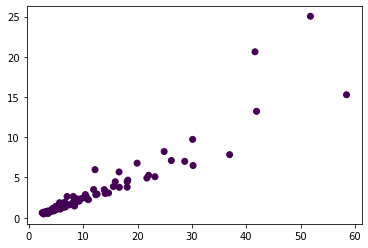

In [66]:
# Training
# Using KMeans clustering (NOT VERY  ACCURATE)
#num_clusters = 3
#kmean_labels = KMeans(n_clusters=num_clusters).fit_predict(X)
kmean_labels = classifier.predict(X)
#kmean_labels = classifier.predict(feature_X)
print(np.unique(kmean_labels, return_counts=True))
print(kmean_labels)

plt.scatter(feature_X[:,0], feature_X[:,1], c=kmean_labels)
#plt.scatter(feature_X[:,0], feature_X[:,1], c=y )

plt.show()

In [67]:
# Evaluation of clustering result of KMeans (true_labels, predicted_labels)
homogeneity_score(y, kmean_labels), completeness_score(y, kmean_labels), v_measure_score(y, kmean_labels), accuracy_score(y, kmean_labels), confusion_matrix(y, kmean_labels)

(0.0,
 1.0,
 0.0,
 0.9655172413793104,
 array([[112,   0],
        [  4,   0]], dtype=int64))